Обучить сиамскую сеть для верификации лиц на датасете LFW

Библиотеки: [Python, Tensorflow]

In [2]:
# !pip install tensorflow_datasets

In [1]:
import tensorflow as tf

gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds

### Загрузка данных.

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'], 
    data_dir='./LFW', 
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='./LFW/lfw/0.1.0',
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        numbe

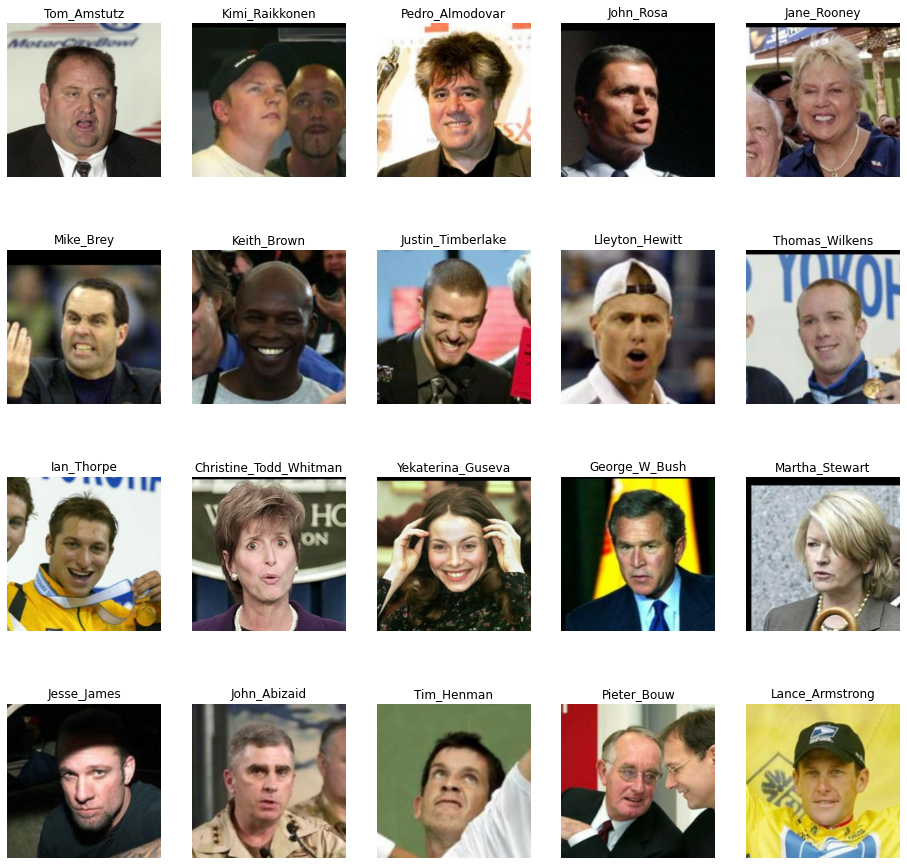

In [5]:
shape = (4, 5)
width = 16

fig, ax = plt.subplots(*shape, figsize=(width, shape[0] * (width//shape[1] + 1)))

for i, (label, img) in enumerate(iter(train_ds.take(np.prod(shape)))):
    pos = ax[i//shape[1], i%shape[1]]
    pos.imshow(img)
    pos.set_title(label.numpy().decode())
    pos.axis('off')
plt.show()

### Подготовка данных.

In [6]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'], 
    data_dir='./LFW', 
)

In [8]:
BATCH_SIZE = 64
INP_SIZE = 128


def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

### Построение модели.

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [10]:
def conv_block(n_filters, prev_layer, random_state=None):
    '''
    Сверточный блок:
    2 сверточных слоя (3, 3) с ф-цией активации 'relu'
    
    '''
    tf.random.set_seed(random_state)
    x = layers.Conv2D(n_filters, (3, 3), padding='same')(prev_layer)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(n_filters, (3, 3))(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [11]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [12]:
EMB_SIZE = 300


inputs = layers.Input(shape=(INP_SIZE, INP_SIZE, 3))

# Conv (128, 128, 3) --> (63, 63, 64)
x = conv_block(32, inputs)
# Conv (63, 63, 64) --> (30, 30, 128)
x = conv_block(64, x)
# Conv (30, 30, 128) --> (14, 14, 256)
x = conv_block(128, x)

# Pooling (14, 14, 256) --> (256)
x = layers.GlobalAveragePooling2D()(x)

# FC (256) --> (1024)
x = layers.Dense(1024)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# Output 
outputs = layers.Dense(EMB_SIZE)(x)

model = Model(inputs, outputs)
model.build([None, INP_SIZE, INP_SIZE, 3])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496 

### Обучение модели.

In [13]:
LEARNING_RATE = 1e-4
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [14]:
import time


best_loss = 10.


def evaluate_model(model, ds, criterion, save_path=None):
    loss = 0.
    for inputs, labels in ds:

        embs = model(inputs)
        loss += criterion(embs, labels).numpy()
    
    val_loss = loss / len(ds)
    
    global best_loss
    if save_path and val_loss < best_loss:
        best_loss = val_loss
        model.save_weights(save_path)
    
    print(
        f'- val_loss: {val_loss:.4f}', 
        end='\n')

    return val_loss


def epoch_training(model, criterion, optimizer, train_set):
    
    running_loss = 0.0
    
    n_steps = len(train_set)
    steps_n_signs = len(str(n_steps))
    
    for i, (inputs, labels) in enumerate(train_set):
        start_time = time.time()
        
        # Forward
        with tf.GradientTape() as tape:
            embs = model(inputs)
            loss = criterion(embs, labels)

        # Backward
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        running_loss += loss.numpy()
        epoch_loss = running_loss / (i + 1)
        
        step_duration = time.time() - start_time
        duration = step_duration * n_steps

        print(
            '\r' \
            f'step [{str(i + 1).zfill(steps_n_signs)}/{n_steps}] ' \
            f'- loss: {epoch_loss:.4f} ',
            end='', flush=True)
    
    return epoch_loss


def model_training(model, criterion, optimizer, epochs, train_set, valid_set=None, save_path=None):
    history = {
        'loss': []
    }
    if valid_set:
        history['val_loss'] = []
    
    for epoch in range(epochs):

        start_time = time.time()
        
        print(
            f'Epoch {epoch + 1}/{epochs}', 
            end='\n')
        
        epoch_loss = epoch_training(model, criterion, optimizer, train_set)
        
        duration = round(time.time() - start_time)
        
        if valid_set:
            val_loss = evaluate_model(model, valid_set, criterion, save_path=save_path)
            history['val_loss'].append(val_loss)
        
        history['loss'].append(epoch_loss)
        
        print(
            '\n' \
            f'duration: {duration}s ({round((duration/len(train_set)) * 1000)}ms/step)\n', 
            end='\n')
        
    if save_path:
        model.load_weights(save_path)

    print('Training is finished!')
    
    return model, history

In [15]:
model, hist = model_training(model, 
                            criterion=contrastive_loss, 
                            optimizer=optimizer, 
                            epochs=25, 
                            train_set=train_ds, 
                            valid_set=test_ds, 
                            save_path='./weights/best_weights.h5')

Epoch 1/25
step [186/186] - loss: 20.6319 - val_loss: 13.7849

duration: 48s (258ms/step)

Epoch 2/25
step [186/186] - loss: 8.5895  - val_loss: 10.4294

duration: 41s (220ms/step)

Epoch 3/25
step [186/186] - loss: 9.1356  - val_loss: 4.8223

duration: 41s (220ms/step)

Epoch 4/25
step [186/186] - loss: 4.0357 - val_loss: 3.3803

duration: 41s (220ms/step)

Epoch 5/25
step [186/186] - loss: 4.3769  - val_loss: 3.0292

duration: 41s (220ms/step)

Epoch 6/25
step [186/186] - loss: 7.3758  - val_loss: 3.2457

duration: 41s (220ms/step)

Epoch 7/25
step [186/186] - loss: 4.4614  - val_loss: 3.6588

duration: 41s (220ms/step)

Epoch 8/25
step [186/186] - loss: 5.8873   - val_loss: 3.0401

duration: 41s (220ms/step)

Epoch 9/25
step [186/186] - loss: 3.7165  - val_loss: 2.7242

duration: 41s (220ms/step)

Epoch 10/25
step [186/186] - loss: 5.3961  - val_loss: 3.5357

duration: 41s (220ms/step)

Epoch 11/25
step [186/186] - loss: 4.4410 - val_loss: 3.1312

duration: 41s (220ms/step)

Epoch 1

### Инференс модели.

In [16]:
evaluate_model(model, test_ds, contrastive_loss)

- val_loss: 0.8864


0.8863865867257118

In [17]:
name1 = b'Jennifer_Lopez'
name2 = b'Robert_De_Niro'

images_names = []

for images_batch, names_batch in iter(test_ds):
    mask = (names_batch == name1) | (names_batch == name2)
    
    images = images_batch[mask]
    names = names_batch[mask]
    
    images_names += list(zip(images, names))

In [18]:
from itertools import combinations

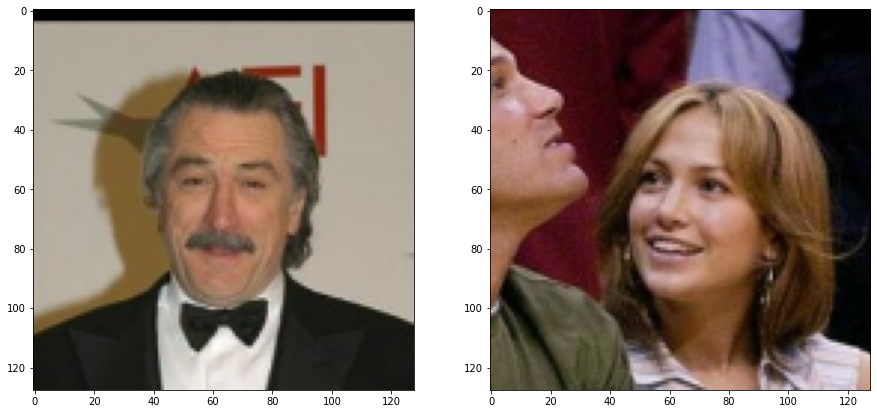

Robert_De_Niro <-> Jennifer_Lopez: 15.4742


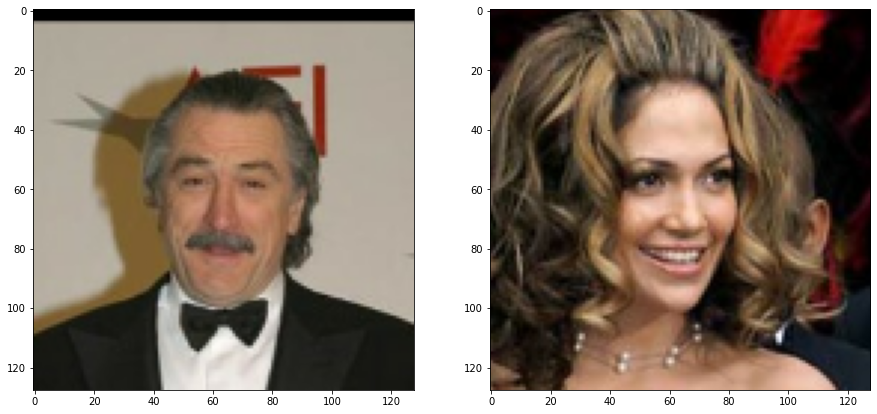

Robert_De_Niro <-> Jennifer_Lopez: 17.9215


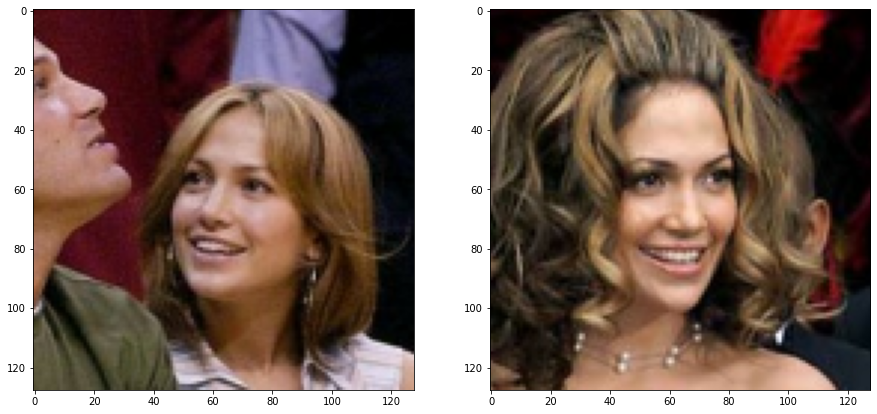

Jennifer_Lopez <-> Jennifer_Lopez: 3.7812


In [22]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


for (img1, name1), (img2, name2) in combinations(images_names, 2):

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    plt.show()
    
    emb1 = model(img1[None])
    emb2 = model(img2[None])
    print(f'{name1.numpy().decode()} <-> {name2.numpy().decode()}:', round(diff(emb1, emb2), 4))